In [6]:
import numpy as np

import math
from functools import cached_property
from typing import Dict, List

import pandas as pd

import matplotlib.pyplot as plt

In [200]:


class Pendulum:
    r"""Class for generating time series data for a pendulum.

    The pendulum is modelled as a damped harmonic oscillator, i.e.,

    $$
    \theta(t) = \theta(0) \cos(2 \pi t / p)\exp(-\beta t),
    $$

    where $\theta(t)$ is the angle of the pendulum at time $t$.
    The period $p$ is calculated using

    $$
    p = 2 \pi \sqrt(L / g),
    $$

    with $L$ being the length of the pendulum
    and $g$ being the surface gravity.

    :param length: Length of the pendulum.
    :param gravity: Acceleration due to gravity.
    """

    def __init__(self, length: float, gravity: float = 9.81) -> None:
        self.length = length
        self.gravity = gravity

    @cached_property
    def period(self) -> float:
        """Calculate the period of the pendulum."""
        return 2 * math.pi * math.sqrt(self.length / self.gravity)

    def __call__(
        self,
        num_periods: int,
        num_samples_per_period: int,
        initial_angle: float = 0.1,
        beta: float = 0,
    ) -> Dict[str, List[float]]:
        """Generate time series data for the pendulum.

        Returns a list of floats representing the angle
        of the pendulum at each time step.

        :param num_periods: Number of periods to generate.
        :param num_samples_per_period: Number of samples per period.
        :param initial_angle: Initial angle of the pendulum.
        """
        time_step = self.period / num_samples_per_period
        steps = []
        time_series = []
        for i in range(num_periods * num_samples_per_period):
            t = i * time_step
            angle = (
                initial_angle
                * math.cos(2 * math.pi * t / self.period)
                * math.exp(-beta * t)
            )
            steps.append(t)
            time_series.append(angle)

        return {"t": steps, "theta": time_series}


In [201]:

pen = Pendulum(length=100)
df = pd.DataFrame(pen(30, 400, initial_angle=1, beta=0))
df.rename(columns={"t": "date"}, inplace=True)

df["date"]= [
    f"{i.year}-{i.month:02d}-{i.day:02d}"
    for i in 
    pd.date_range(
        start='2023-01-01', periods=len(df), freq='D'
    )
]

In [96]:
df

,date,theta
0,2023-01-01,1.000000
1,2023-01-02,0.999877
2,2023-01-03,0.999507
3,2023-01-04,0.998890
4,2023-01-05,0.998027
...,...,...
11995,2055-11-04,0.996917
11996,2055-11-05,0.998027
11997,2055-11-06,0.998890
11998,2055-11-07,0.999507


In [97]:
df.to_csv("../datasets/sine_data.csv", index=False)

<Axes: xlabel='date'>

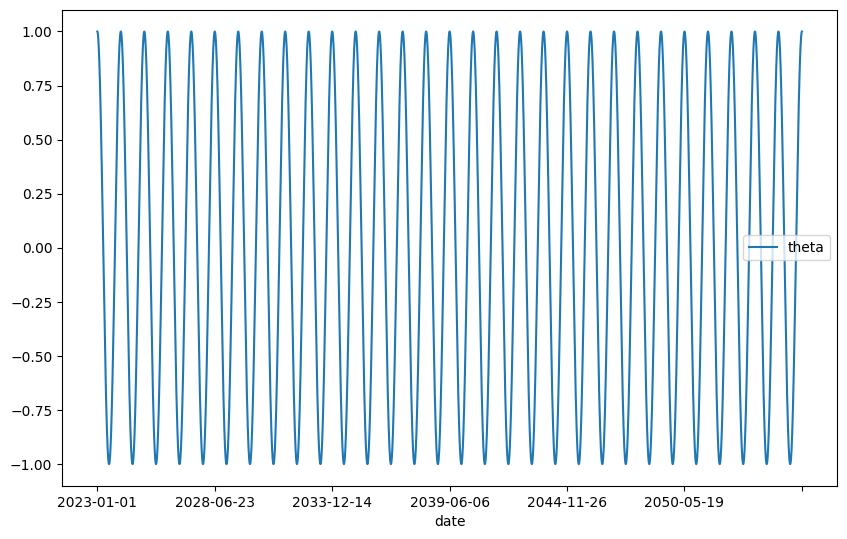

In [98]:

_, ax = plt.subplots(figsize=(10, 6.18))
df.plot(x="date", y="theta", ax=ax)

# Eval and Embedding

In [202]:
import plotly.express as px

In [203]:
import sys
sys.path.insert(0,'../')

In [204]:
from ts2vec import TS2Vec
import tasks
import datautils

In [205]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

In [206]:
dataset = "sine_data"

In [251]:

# def load_forecast_csv(name, univar=False, time_features=True):

name = dataset
univar = True
time_features = False

raw_data = pd.read_csv(f'../datasets/{name}.csv', index_col='date', parse_dates=True)
if time_features:
    dt_embed = datautils._get_time_features(raw_data.index)
    n_covariate_cols = dt_embed.shape[-1]
else:
    dt_embed = None
    n_covariate_cols = 0

if univar:
    if name in ('ETTh1', 'ETTh2', 'ETTm1', 'ETTm2'):
        data = raw_data[['OT']]
    elif name == 'electricity':
        data = raw_data[['MT_001']]
    else:
        data = raw_data.iloc[:, -1:]


In [252]:

# data = data.to_numpy()
print(f"{data.shape=}")
if name == 'ETTh1' or name == 'ETTh2':
    train_slice = slice(None, 12*30*24)
    valid_slice = slice(12*30*24, 16*30*24)
    test_slice = slice(16*30*24, 20*30*24)
elif name == 'ETTm1' or name == 'ETTm2':
    train_slice = slice(None, 12*30*24*4)
    valid_slice = slice(12*30*24*4, 16*30*24*4)
    test_slice = slice(16*30*24*4, 20*30*24*4)
else:
    train_slice = slice(None, int(0.6 * len(data)))
    valid_slice = slice(int(0.6 * len(data)), int(0.8 * len(data)))
    test_slice = slice(int(0.8 * len(data)), None)

scaler = StandardScaler().fit(data[train_slice])
print(f"{data[train_slice].shape=}")
print(f"{data.shape=}")
data = scaler.transform(data)
print(f"{data.shape=}")
if name in ('electricity'):
    data = np.expand_dims(data.T, -1)  # Each variable is an instance rather than a feature
else:
    data = np.expand_dims(data, 0)
    print(f"{data.shape=}")

if n_covariate_cols > 0:
    dt_scaler = StandardScaler().fit(dt_embed[train_slice])
    dt_embed = np.expand_dims(dt_scaler.transform(dt_embed), 0)
    data = np.concatenate([np.repeat(dt_embed, data.shape[0], axis=0), data], axis=-1)

if name in ('ETTh1', 'ETTh2', 'electricity'):
    pred_lens = [24, 48, 168, 336, 720]
else:
    pred_lens = [24, 48, 96, 288, 672]

    # return data, train_slice, valid_slice, test_slice, scaler, pred_lens, n_covariate_cols


data.shape=(12000, 1)
data[train_slice].shape=(7200, 1)
data.shape=(12000, 1)
data.shape=(12000, 1)
data.shape=(1, 12000, 1)


In [253]:
print(f"{data.shape=}")

data.shape=(1, 12000, 1)


In [209]:
n_covariate_cols

0

In [210]:
from utils import init_dl_program, name_with_datetime, pkl_save, data_dropout

In [211]:
seed = 42
max_threads = 8
gpu = 0

In [212]:
device = init_dl_program(gpu, seed=seed, max_threads=max_threads)

In [213]:
batch_size = 8
lr = 0.001
# output_dims = 320
output_dims = 20
max_train_length = 3000

In [214]:
config = dict(
    batch_size=batch_size,
    lr=lr,
    output_dims=output_dims,
    max_train_length=max_train_length
)

In [215]:
model = TS2Vec(
    input_dims=data.shape[-1],
    device=device,
    **config
)

In [221]:
# run_dir = "../training/sine_data__forecast_univar_20251104_224350"
# run_dir = "../training/sine_data__forecast_univar_20251105_212911"
# run_dir = "../training/sine_data__forecast_univar_20251105_221721"
run_dir = "../training/sine_data__forecast_univar_20251105_224711"

In [223]:
model.load(f'{run_dir}/model.pkl')

## Eval

In [224]:
import time


In [225]:
n_covariate_cols

0

In [226]:
padding = 200
t = time.time()
all_repr = model.encode(
    data,
    causal=True,
    sliding_length=1,
    sliding_padding=padding,
    batch_size=256
)
ts2vec_infer_time = time.time() - t

train_repr = all_repr[:, train_slice]
valid_repr = all_repr[:, valid_slice]
test_repr = all_repr[:, test_slice]

train_data = data[:, train_slice, n_covariate_cols:]
valid_data = data[:, valid_slice, n_covariate_cols:]
test_data = data[:, test_slice, n_covariate_cols:]

ours_result = {}
lr_train_time = {}
lr_infer_time = {}
out_log = {}
for pred_len in pred_lens[:1]:
    train_features, train_labels = tasks.forecasting.generate_pred_samples(train_repr, train_data, pred_len, drop=padding)
    valid_features, valid_labels = tasks.forecasting.generate_pred_samples(valid_repr, valid_data, pred_len)
    test_features, test_labels = tasks.forecasting.generate_pred_samples(test_repr, test_data, pred_len)

    t = time.time()
    lr = tasks._eval_protocols.fit_ridge(train_features, train_labels, valid_features, valid_labels)
    lr_train_time[pred_len] = time.time() - t
    
    t = time.time()
    test_pred = lr.predict(test_features)
    lr_infer_time[pred_len] = time.time() - t

    ori_shape = test_data.shape[0], -1, pred_len, test_data.shape[2]
    
    
    if test_data.shape[0] > 1:
        print("swap axis")
        test_pred_inv = scaler.inverse_transform(test_pred.swapaxes(0, 3)).swapaxes(0, 3)
        test_labels_inv = scaler.inverse_transform(test_labels.swapaxes(0, 3)).swapaxes(0, 3)
    else:
        test_pred_inv = scaler.inverse_transform(test_pred)
        test_labels_inv = scaler.inverse_transform(test_labels)

    test_pred = test_pred.reshape(ori_shape)
    test_labels = test_labels.reshape(ori_shape)
        
    out_log[pred_len] = {
        'norm': test_pred,
        'raw': test_pred_inv,
        'norm_gt': test_labels,
        'raw_gt': test_labels_inv
    }
    ours_result[pred_len] = {
        'norm': tasks.forecasting.cal_metrics(test_pred, test_labels),
        'raw': tasks.forecasting.cal_metrics(test_pred_inv, test_labels_inv)
    }
    
eval_res = {
    'ours': ours_result,
    'ts2vec_infer_time': ts2vec_infer_time,
    'lr_train_time': lr_train_time,
    'lr_infer_time': lr_infer_time
}

In [227]:
df_0_inv = pd.DataFrame({
    "index": np.arange(test_pred_inv.shape[1]),
    "pred": test_pred_inv[0,:],
    "label": test_labels_inv[0,:],
})

In [228]:
px.line(
    df_0_inv.melt(
        id_vars="index",
        value_vars=["pred", "label"],
        var_name="type",
        value_name="value"
    ),
    x="index",
    y="value",
    color="type"
)

## Embedding

In [229]:
from torch.utils.data import TensorDataset, DataLoader
import torch

In [230]:
t_dataset = TensorDataset(torch.from_numpy(data).to(torch.float))
loader = DataLoader(t_dataset, batch_size=batch_size)

In [231]:
test_repr = model.encode(data)

test_repr_full_series = model.encode(data, encoding_window='full_series')  # n_instances x output_dims


# Sliding inference for test set
# test_repr = model.encode(
#     data,
#     causal=True,
#     sliding_length=1,
#     sliding_padding=50
# )  # n_instances x n_timestamps x output_dims

In [232]:
test_repr.shape, test_repr_full_series.shape, data.shape

((1, 12000, 20), (1, 20), (1, 12000, 1))

In [233]:
px.imshow(
    test_repr.squeeze()[:1000].T,
    labels={"x": "Timestamp", "y": "Dimensions"},
    title="TS2Vec Representation Heatmap",
    aspect="auto",
    color_continuous_scale='gray'
)

In [234]:
px.line(
    raw_data[["theta"]][:1000].reset_index(),
    x="date",
    y="theta"
)

In [235]:
px.line(
    y=test_repr_full_series[0]
)

Visualations for publications

Text(0.5, 0, 'Time Step')

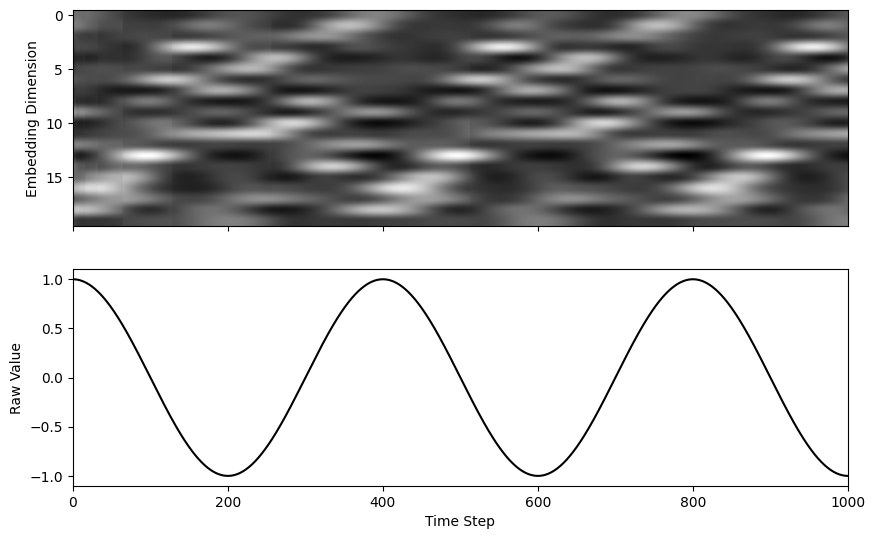

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 6.18))

fig_seq_len = 1000

ax[0].imshow(
    test_repr.squeeze()[:fig_seq_len].T,
    aspect='auto',
    cmap='gray',
)

ax[0].set_ylabel("Embedding Dimension")
ax[0].set_xticklabels([])


ax[1].plot(
    raw_data["theta"][:1000].values,
    label="Raw Data",
    color="k"
)

ax[1].set_ylabel("Raw Value")
ax[1].set_xlim(0, fig_seq_len)
ax[1].set_xlabel("Time Step")

In [237]:

pen = Pendulum(length=100)
df_damped = pd.DataFrame(pen(30, 400, initial_angle=1, beta=0.01))
df_damped.rename(columns={"t": "date"}, inplace=True)

df_damped["date"]= [
    f"{i.year}-{i.month:02d}-{i.day:02d}"
    for i in 
    pd.date_range(
        start='2023-01-01', periods=len(df_damped), freq='D'
    )
]

<Axes: xlabel='date'>

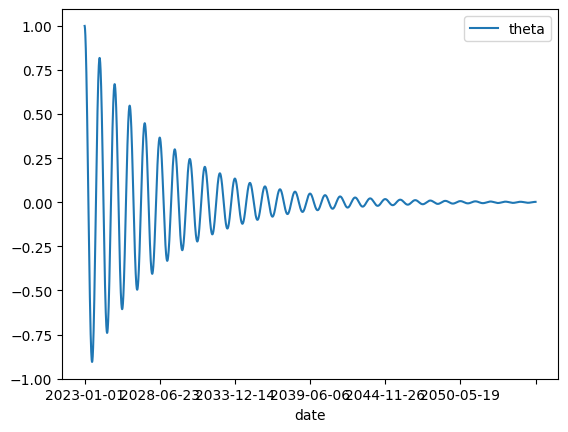

In [238]:
df_damped.plot(x="date", y="theta")

In [239]:
df_damped[["theta"]].values.shape

(12000, 1)

In [259]:
data_damped = scaler.transform(
    df_damped[["theta"]]
)

data_damped = np.expand_dims(data_damped, 0)

In [260]:
data.shape, df_damped[["theta"]].values.shape, data_damped.shape

((1, 12000, 1), (12000, 1), (1, 12000, 1))

In [261]:
test_repr_damped = model.encode(data_damped)

Text(0.5, 0, 'Time Step')

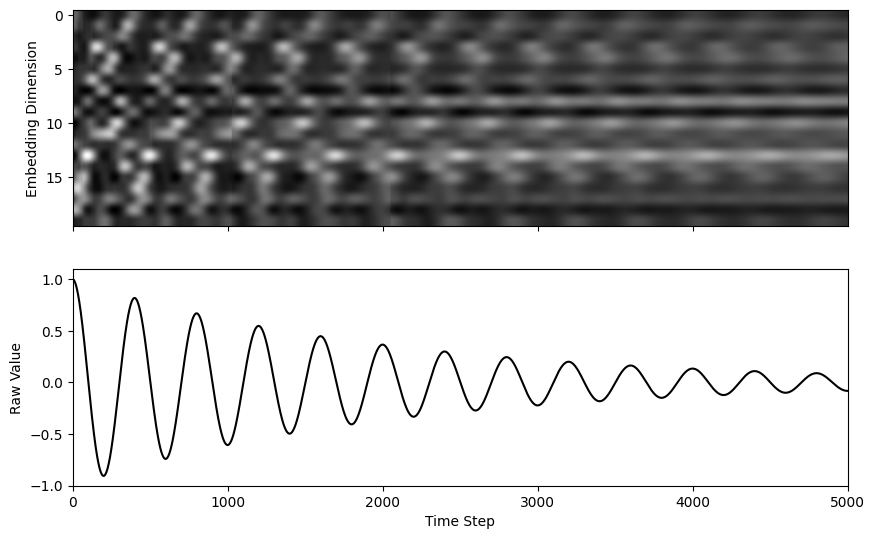

In [265]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 6.18))

fig_seq_len = 5000

ax[0].imshow(
    test_repr_damped.squeeze()[:fig_seq_len].T,
    aspect='auto',
    cmap='gray',
)

ax[0].set_ylabel("Embedding Dimension")
ax[0].set_xticklabels([])


ax[1].plot(
    df_damped["theta"][:fig_seq_len].values,
    label="Raw Data",
    color="k"
)

ax[1].set_ylabel("Raw Value")
ax[1].set_xlim(0, fig_seq_len)
ax[1].set_xlabel("Time Step")

# fig.suptitle("TS2Vec Representation of Damped Pendulum vs. Raw Data")